In [76]:
#library & package. 
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import json, tweepy, requests, re, string
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup as bs

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Business Understanding

Topik yang dipilih adalah fresh graduate.Topik tersebut dipilih karena sekarang sedang banyak mahasiswa yang baru lulus/wisuda pada bulan-bulan ini.Karena hal tersebut masyrakat akan banyak update pada sosial media salah satunya twiter terkait fresh graduate,mulai dari ngetwet pengalaman kuliah,sampai dengan info lowongan.Dari topik tersebut dapat dibuat klasifikasi  terkait artikel/tweet tentang fresh graduate, untuk mengetahui ada berapa banyak kategori yang bisa dibuat dan detail terkait kategori tersebut.

Data Collection

In [77]:
with open("token.json")as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

In [78]:
api = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

In [79]:
query = "fresh graduate -is:retweet lang:id"

response = tweepy.Paginator(api.search_recent_tweets,
                          query = query,
                          start_time = "2022-09-01T00:00:00Z",
                          end_time = "2022-09-03T00:00:00Z",
                          max_results=100
                          ).flatten(limit=2000)
tweets = [tweet.text.strip() for tweet in response]

In [80]:
df_tweets = pd.DataFrame(tweets, columns=["artikel"])
df_tweets

,artikel
0,Lowongan Kerja Fresh Graduate Program Samosir ...
1,Lowongan Kerja Indonesia Lulusan D3 September ...
2,Lowongan Kerja Fresh Graduate Program Belitung...
3,oh begini nasibnya fresh graduate yang pengang...
4,Lowongan Kerja Fresh Graduate Program Bangka –...
...,...
203,Info loker dom bogor dong buat SMK fresh gradu...
204,"@collegemenfess sama aja nder, tapi kalo kerja..."
205,"Fresh Graduate Wajib Tahu, Ini Hal yang Mesti ..."
206,[cm] di LinkedIn ada ga yang buka lowongan bua...


In [81]:
# data tambahan dari website
user_agent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1) AppleWebKit/602.2.14 (KHTML, like Gecko) Version/10.0.1 Safari/602.2.14'
headers = {'User-Agent': user_agent,'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'}

alamat = "https://www.kompas.com/edu/read/2022/09/04/132700571/tips-melamar-kerja-bagi-fresh-graduate-bukan-dari-universitas-ternama"
req = Request(alamat, headers=headers)
html = urlopen(req)

In [82]:
data = bs(html, 'html.parser')
box = data.find("div",{"class":"read__content"})

hidelabel = box.findAll('strong')
for delete in hidelabel:
    delete.decompose()
items = box.findAll("p")
hasil = [item.get_text() for item in items]

In [83]:
print(hasil)

['', ' - Saat ini perusahaan sangat spesifik dalam memberikan persyaratan dalam proses rekrutmen karyawan. Hal ini tentu menjadi tantangan tersendiri bagi para fresh graduate.', 'Bahkan di beberapa persyaratan lowongan kerja, tertera syarat kandidat harus berasal dari universitas ternama dengan peringkat terbaik.', 'Lantas bagaimana fresh graduate dari universitas yang kurang terkenal? Syarat tersebut tentu menjadi beban tersendiri karena kinerja seseorang tidak hanya ditentukan berdasarkan almamater semata.', 'Menyikapi kondisi ini, ada beberapa tips yang bisa dilakukan para fresh graduate. Melansir dari laman website penyedia lowongan kerja JobStreet, membagikan tips melamar pekerjaan bagi fresh graduate dari universitas yang kurang ternama. Apa saja tipsnya? Yuk simak informasi berikut ini:', '', '', 'Meski kamu bukan lulusan dari kampus ternama, kualitas dirimu bisa diperlihatkan dari pengalaman berorganisasi selama menjadi mahasiswa.', 'Dengan aktif berorganisasi, kamu bisa memili

In [84]:
df1 = pd.DataFrame(hasil)
df1.columns = ['artikel']
df1

,artikel
0,
1,- Saat ini perusahaan sangat spesifik dalam m...
2,"Bahkan di beberapa persyaratan lowongan kerja,..."
3,Lantas bagaimana fresh graduate dari universit...
4,"Menyikapi kondisi ini, ada beberapa tips yang ..."
5,
6,
7,"Meski kamu bukan lulusan dari kampus ternama, ..."
8,"Dengan aktif berorganisasi, kamu bisa memiliki..."
9,Mengikuti organisasi juga bisa menjadi bukti u...


In [85]:
# gabungan data tweets dan sumber tambahan
df = pd.concat([df1,df_tweets.loc[:]]).reset_index(drop=True)
df

,artikel
0,
1,- Saat ini perusahaan sangat spesifik dalam m...
2,"Bahkan di beberapa persyaratan lowongan kerja,..."
3,Lantas bagaimana fresh graduate dari universit...
4,"Menyikapi kondisi ini, ada beberapa tips yang ..."
...,...
215,Info loker dom bogor dong buat SMK fresh gradu...
216,"@collegemenfess sama aja nder, tapi kalo kerja..."
217,"Fresh Graduate Wajib Tahu, Ini Hal yang Mesti ..."
218,[cm] di LinkedIn ada ga yang buka lowongan bua...


In [86]:
# to csv
df.to_csv('fresh_graduate.csv')

Text Preprocessing

In [87]:
#case folding
def case_folding(text):
    kalimat = re.sub("(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|(\d+)", " ", text.lower())
    hasil = kalimat.translate(str.maketrans("","",string.punctuation)).strip()
    return hasil

In [88]:
# stopword bahasa indonesai
stopword = pd.read_csv('stopwords.txt',names=['stw'],header=None)
stopwords = stopword['stw'].values.tolist()
# ditambah kata kunci yang dicari
tambah = 'fresh'
tambah1 = 'graduate'
stopwords.append(tambah)
stopwords.append(tambah1)

In [89]:
# stopword
def stop_words(text):
    texts = text.split()
    
    resultword = [word for word in texts if word not in stopwords]
    hasil = ' '.join(resultword)
    return hasil

In [90]:
#  slang word
slangWords = ['sabi','sabun','sabeb','kemek','kilab','cabs','sutup','selow',' woles','baper','php','rokum','sotoy','btw']
def slang_words(text):
    texts = text.split()
    
    resultword = [word for word in texts if word not in slangWords]
    hasil = ' '.join(resultword)
    return hasil

In [91]:
df['clean_artikel'] = df['artikel'].apply(case_folding)
df['clean_artikel'] = df['clean_artikel'].apply(stop_words)
df['clean_artikel'] = df['clean_artikel'].apply(slang_words)
df

,artikel,clean_artikel
0,,
1,- Saat ini perusahaan sangat spesifik dalam m...,perusahaan spesifik persyaratan proses rekrutm...
2,"Bahkan di beberapa persyaratan lowongan kerja,...",persyaratan lowongan kerja tertera syarat kand...
3,Lantas bagaimana fresh graduate dari universit...,lantas universitas terkenal syarat beban terse...
4,"Menyikapi kondisi ini, ada beberapa tips yang ...",menyikapi kondisi tips melansir laman website ...
...,...,...
215,Info loker dom bogor dong buat SMK fresh gradu...,info loker dom bogor smk butuh kerjaan banget ...
216,"@collegemenfess sama aja nder, tapi kalo kerja...",aja nder kalo kerja praktek kayaknya undergrad...
217,"Fresh Graduate Wajib Tahu, Ini Hal yang Mesti ...",wajib mesti diperhatikan bikin cv ats
218,[cm] di LinkedIn ada ga yang buka lowongan bua...,cm linkedin ga buka lowongan magang statusnya ...


Text Data Analysis

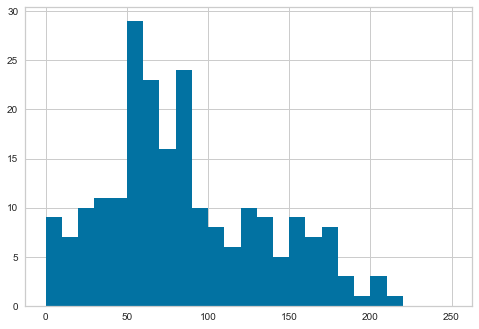

In [92]:
# Distribusi Frekuensi karakter per artikel
bin_range = np.arange(0, 260, 10)
df['clean_artikel'] .str.len().hist(bins=bin_range)
plt.show()

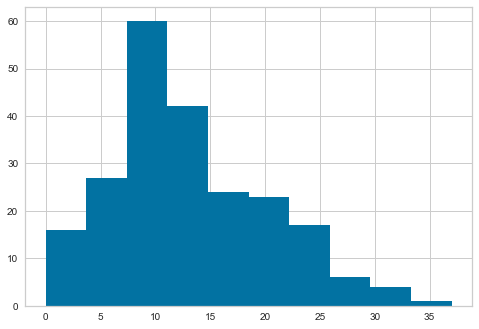

In [93]:
# Distribusi panjang kata per artikel
df['clean_artikel'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: len(x)).hist()
plt.show()

C:\Users\ASUS\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


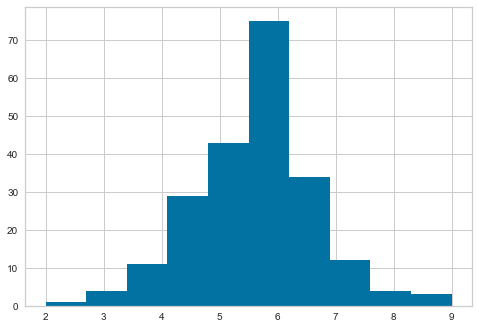

In [94]:
# Distribusi panjang rata-rata kata per artikel
df['clean_artikel'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.show()

In [95]:
df['clean_artikel_frequency']  = df['clean_artikel'] .apply(lambda x: word_tokenize(x))
cleans = [word for clean in df['clean_artikel_frequency']  for word in clean]
fqdist = FreqDist(cleans)
most_common_word = fqdist.most_common(1000)

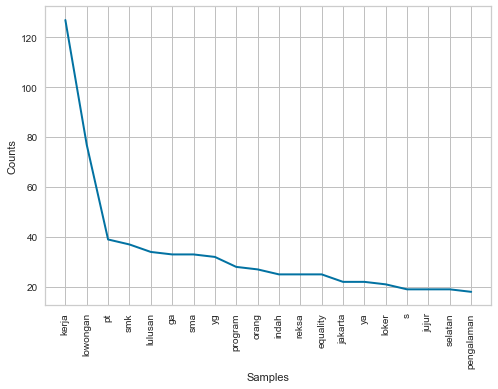

In [96]:
fqdist.plot(20,cumulative=False)

plt.show()

In [97]:
most_common_word

[('kerja', 127),
 ('lowongan', 77),
 ('pt', 39),
 ('smk', 37),
 ('lulusan', 34),
 ('ga', 33),
 ('sma', 33),
 ('yg', 32),
 ('program', 28),
 ('orang', 27),
 ('indah', 25),
 ('reksa', 25),
 ('equality', 25),
 ('jakarta', 22),
 ('ya', 22),
 ('loker', 21),
 ('s', 19),
 ('jujur', 19),
 ('selatan', 19),
 ('pengalaman', 18),
 ('cabang', 18),
 ('disiplin', 18),
 ('hubungi', 18),
 ('wa', 18),
 ('kalo', 17),
 ('aja', 17),
 ('perusahaan', 16),
 ('info', 13),
 ('udah', 13),
 ('cari', 13),
 ('september', 12),
 ('syarat', 11),
 ('cv', 11),
 ('melamar', 10),
 ('d', 10),
 ('kuliah', 10),
 ('nya', 10),
 ('dunia', 9),
 ('amp', 9),
 ('banget', 9),
 ('pekerjaan', 8),
 ('indonesia', 8),
 ('sih', 8),
 ('gak', 8),
 ('lamar', 8),
 ('dm', 8),
 ('medan', 7),
 ('gaji', 7),
 ('work', 7),
 ('anak', 7),
 ('magang', 7),
 ('minimal', 7),
 ('susah', 7),
 ('lokermedan', 6),
 ('lupakerja', 6),
 ('dapet', 6),
 ('cm', 6),
 ('temen', 6),
 ('gimana', 6),
 ('sales', 6),
 ('nder', 6),
 ('ambil', 6),
 ('karna', 6),
 ('nyari', 

In [98]:
#  Distribusi bi-gram
result = pd.Series(nltk.ngrams(cleans, 2)).value_counts()[:25]
print (result)

(lowongan, kerja)          66
(sma, smk)                 27
(kerja, program)           25
(pt, indah)                25
(indah, reksa)             25
(reksa, equality)          25
(lulusan, sma)             21
(kerja, jakarta)           19
(hubungi, wa)              18
(smk, jujur)               18
(disiplin, hubungi)        18
(jujur, disiplin)          18
(selatan, cabang)          18
(orang, lulusan)           18
(cabang, orang)            18
(jakarta, selatan)         18
(wa, lowongan)             14
(dunia, kerja)              9
(info, loker)               8
(are, welcome)              6
(lokermedan, lupakerja)     6
(minimal, sma)              5
(lamar, loker)              5
(kerja, administrasi)       5
(equality, lowongan)        5
dtype: int64


In [99]:
#  slang word pembersihan + kata kunci pencarian
slangWords = ['sabi','sabun','sabeb','kilab','cabs','sutup','selow',' woles','baper','php','rokum','sotoy','btw','krn','rl','bgt','w','fak','lbh','tp','bgt','sm','wkwk','trs','emg','dh','gt','jln','eh','dr','blm','se','ma','tmn','k','putus','amp','twb','nd','buset']
def slang_words(text):
    texts = text.split()
    
    resultword = [word for word in texts if word not in slangWords]
    hasil = ' '.join(resultword)
    return hasil

In [100]:
df['clean_artikel'] = df['clean_artikel'].apply(slang_words)
df.drop('clean_artikel_frequency', inplace=True, axis=1)
df

,artikel,clean_artikel
0,,
1,- Saat ini perusahaan sangat spesifik dalam m...,perusahaan spesifik persyaratan proses rekrutm...
2,"Bahkan di beberapa persyaratan lowongan kerja,...",persyaratan lowongan kerja tertera syarat kand...
3,Lantas bagaimana fresh graduate dari universit...,lantas universitas terkenal syarat beban terse...
4,"Menyikapi kondisi ini, ada beberapa tips yang ...",menyikapi kondisi tips melansir laman website ...
...,...,...
215,Info loker dom bogor dong buat SMK fresh gradu...,info loker dom bogor smk butuh kerjaan banget ...
216,"@collegemenfess sama aja nder, tapi kalo kerja...",aja nder kalo kerja praktek kayaknya undergrad...
217,"Fresh Graduate Wajib Tahu, Ini Hal yang Mesti ...",wajib mesti diperhatikan bikin cv ats
218,[cm] di LinkedIn ada ga yang buka lowongan bua...,cm linkedin ga buka lowongan magang statusnya ...


Data Processing

In [101]:
# Mengubah data teks menjadi numerik
features = df['clean_artikel']

#create tokenizer for our data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, oov_token='<UNK>')
tokenizer.fit_on_texts(features)


#convert text data to numerical indexes
data_num = tokenizer.texts_to_sequences(features)

#pad data up to SEQ_LEN (note that we truncate if there are more than SEQ_LEN tokens)
data_num = tf.keras.preprocessing.sequence.pad_sequences(data_num, padding="post", maxlen=20)

In [102]:
data_num

array([[   0,    0,    0, ...,    0,    0,    0],
       [  28,  425,  202, ...,    0,    0,    0],
       [ 202,    3,    2, ...,    0,    0,    0],
       ...,
       [ 415,  179, 1184, ...,    0,    0,    0],
       [  57, 1185,    7, ..., 1190,  381,   99],
       [  45,    7,   98, ...,    0,    0,    0]])

Elbow Method to determine the number of clusters to be formed:


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows wi

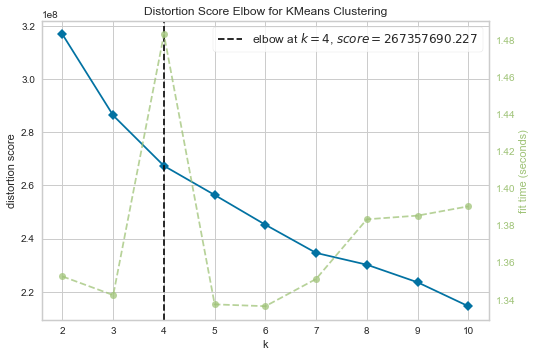

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [103]:
#menentukan banyak kelas yang optimal

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(data_num)
Elbow_M.show()

Modeling

In [104]:
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(data_num)
df["Clusters"] = yhat_AC

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Clusters'>

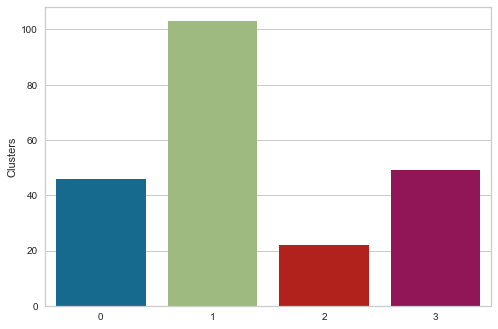

In [105]:
# visualisasi hasil cluster
sns.barplot(df['Clusters'].value_counts().index,df['Clusters'].value_counts())

In [60]:
# data frame setelalah di cluster
df

,artikel,clean_artikel,Clusters
0,,,1
1,- Saat ini perusahaan sangat spesifik dalam m...,perusahaan spesifik persyaratan proses rekrutm...,1
2,"Bahkan di beberapa persyaratan lowongan kerja,...",persyaratan lowongan kerja tertera syarat kand...,1
3,Lantas bagaimana fresh graduate dari universit...,lantas universitas terkenal syarat beban terse...,1
4,"Menyikapi kondisi ini, ada beberapa tips yang ...",menyikapi kondisi tips melansir laman website ...,3
...,...,...,...
215,Info loker dom bogor dong buat SMK fresh gradu...,info loker dom bogor smk butuh kerjaan banget ...,2
216,"@collegemenfess sama aja nder, tapi kalo kerja...",aja nder kalo kerja praktek kayaknya undergrad...,2
217,"Fresh Graduate Wajib Tahu, Ini Hal yang Mesti ...",wajib mesti diperhatikan bikin cv ats,1
218,[cm] di LinkedIn ada ga yang buka lowongan bua...,cm linkedin ga buka lowongan magang statusnya ...,0


In [106]:
df1 = pd.DataFrame(df[(df["Clusters"]== 0)]["clean_artikel"])
df2 = pd.DataFrame(df[(df["Clusters"]== 1)]["clean_artikel"])
df3 = pd.DataFrame(df[(df["Clusters"]== 2)]["clean_artikel"])
df4 = pd.DataFrame(df[(df["Clusters"]== 3)]["clean_artikel"])

df1.columns = ['class_1']
df2.columns = ['class_2']
df3.columns = ['class_3']
df4.columns = ['class_4']

In [107]:
df1['1_artikel_frequency']  = df1["class_1"].apply(lambda x: word_tokenize(x))
cleans_1 = [word for clean in df1['1_artikel_frequency'] for word in clean]
result = pd.Series(nltk.ngrams(cleans_1, 2)).value_counts()[:25]
print (result)

(info, loker)            4
(lowongan, kerja)        4
(pengalaman, kerja)      3
(ga, sih)                3
(lulusan, smk)           3
(dapet, kerja)           2
(lokasi, melamar)        2
(melamar, baca)          2
(end, developer)         2
(kerja, gaji)            2
(syarat, lokasi)         2
(update, september)      2
(dunia, kerja)           2
(hah, hoh)               2
(cari, pengalaman)       2
(pengen, ngelanjutin)    1
(ngelanjutin, basic)     1
(basic, kelistrikan)     1
(banget, pengen)         1
(susah, banget)          1
(smk, susah)             1
(kelistrikan, smk)       1
(smk, cari)              1
(dll, lulusan)           1
(pengalaman, pengen)     1
dtype: int64


In [108]:
df2['2_artikel_frequency']  = df2["class_2"].apply(lambda x: word_tokenize(x))
cleans_2 = [word for clean in df2['2_artikel_frequency'] for word in clean]
result = pd.Series(nltk.ngrams(cleans_2, 2)).value_counts()[:25]
print (result)

(lowongan, kerja)         51
(kerja, program)          25
(indah, reksa)            25
(reksa, equality)         25
(pt, indah)               25
(sma, smk)                19
(selatan, cabang)         18
(cabang, orang)           18
(orang, lulusan)          18
(smk, jujur)              18
(jakarta, selatan)        18
(jujur, disiplin)         18
(disiplin, hubungi)       18
(hubungi, wa)             18
(kerja, jakarta)          18
(lulusan, sma)            18
(wa, lowongan)            16
(equality, lowongan)       9
(kerja, administrasi)      5
(ga, ya)                   3
(info, loker)              3
(pengalaman, kerja)        2
(banten, lowongan)         2
(human, recruitment)       2
(program, labuhanbatu)     2
dtype: int64


In [109]:
df3['3_artikel_frequency']  = df3["class_3"].apply(lambda x: word_tokenize(x))
cleans_3 = [word for clean in df3['3_artikel_frequency'] for word in clean]
result = pd.Series(nltk.ngrams(cleans_3, 2)).value_counts()[:25]
print (result)

(are, welcome)                3
(loker, lowongankerja)        2
(masuk, kuliah)               2
(syarat, pend)                2
(pend, minimal)               2
(minimal, sma)                2
(sma, smk)                    2
(smk, are)                    2
(lamar, loker)                2
(lowongankerja, infoloker)    2
(infoloker, carikerja)        2
(lowongan, magang)            2
(nyapu, ngepel)               2
(loker, teknisi)              2
(magang, statusnya)           1
(lolos, tahap)                1
(lulus, udah)                 1
(sblm, lulus)                 1
(apply, sblm)                 1
(interested, apply)           1
(recruiter, interested)       1
(tag, recruiter)              1
(headhunter, tag)             1
(dilatih, headhunter)         1
(mentor, dilatih)             1
dtype: int64


In [110]:
df4['4_artikel_frequency']  = df4["class_4"].apply(lambda x: word_tokenize(x))
cleans_4 = [word for clean in df4['4_artikel_frequency'] for word in clean]
result = pd.Series(nltk.ngrams(cleans_4, 2)).value_counts()[:25]
print (result)

(lowongan, kerja)             11
(lokermedan, lupakerja)        6
(sma, smk)                     6
(telkom, university)           4
(medan, s)                     4
(dunia, kerja)                 4
(campus, hiring)               4
(perusahaan, yg)               3
(oh, gini)                     3
(september, pt)                3
(s, s)                         3
(kerja, medan)                 3
(medan, lulusan)               3
(d, medan)                     3
(syarat, pend)                 3
(lulusan, d)                   3
(pend, minimal)                3
(minimal, sma)                 3
(smk, are)                     3
(are, welcome)                 3
(infoloker, carikerja)         3
(lowongankerja, infoloker)     3
(loker, lowongankerja)         3
(lamar, loker)                 3
(d, september)                 3
dtype: int64


Worcloud

In [113]:
# dataframe to teks
df1.to_csv(r'class_1.txt', header=None, index=None, sep=' ', mode='a')
df2.to_csv(r'class_2.txt', header=None, index=None, sep=' ', mode='a')
df3.to_csv(r'class_3.txt', header=None, index=None, sep=' ', mode='a')
df4.to_csv(r'class_4.txt', header=None, index=None, sep=' ', mode='a')

In [114]:
f1 = open("class_1.txt", "r")
f2 = open("class_2.txt", "r")
f3 = open("class_3.txt", "r")
f4 = open("class_4.txt", "r")


isi_text1 = f1.read()
isi_text2 = f2.read()
isi_text3 = f3.read()
isi_text4 = f4.read()


wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color='white')

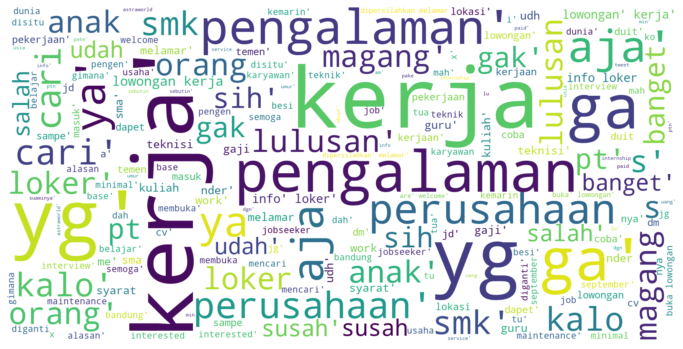

In [115]:
#wordclud class 1
wordcloud.generate(isi_text1)
plt.figure(figsize=(12,10))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

plt.show()

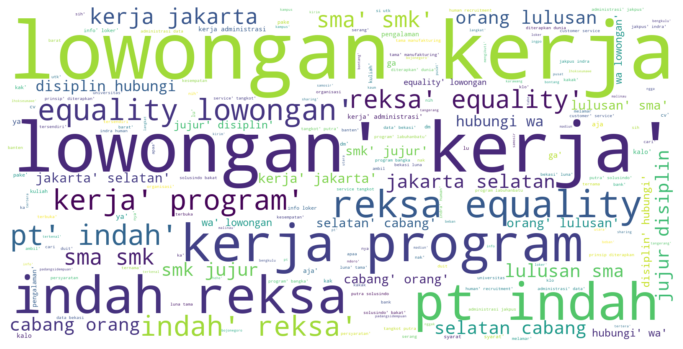

In [116]:
#wordclud class 2
wordcloud.generate(isi_text2)
plt.figure(figsize=(12,10))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

plt.show()

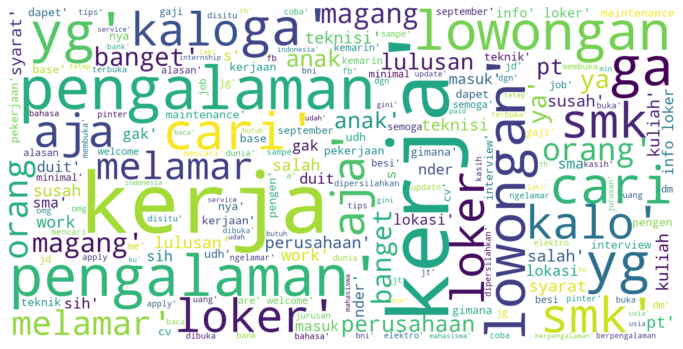

In [117]:
#wordclud class 3
wordcloud.generate(isi_text3)
plt.figure(figsize=(12,10))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

plt.show()

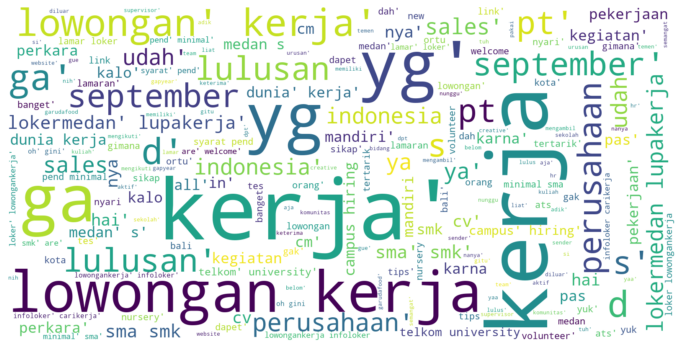

In [73]:
#wordclud class 4
wordcloud.generate(isi_text4)
plt.figure(figsize=(12,10))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

plt.show()